In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import sklearn.model_selection as sms
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.metrics import r2_score
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

In [80]:
df=pd.read_csv("fourrierData.csv")
df.shape

(10000, 10)

In [81]:
df=df.dropna()
df.drop(df[df.callPrice < 0].index, inplace=True)

In [82]:
df.describe()

,kLog,S0,theta,V0,sigma,rho,r,kappa,tau,callPrice
count,9392.000000,9392.000000,9392.000000,9392.000000,9392.000000,9392.000000,9392.000000,9392.000000,9392.000000,9.392000e+03
mean,4.297574,102.210190,0.247910,0.302731,0.264097,-0.472228,0.050464,0.976264,1.700051,4.583970e+01
std,0.990163,56.635239,0.144324,0.144802,0.137277,0.272239,0.029014,0.579562,0.406542,4.603119e+01
min,-4.390968,0.013206,0.000057,0.050130,0.000460,-0.949799,0.000017,0.000064,1.000008,3.562792e-14
25%,3.900013,54.121963,0.123981,0.178715,0.146339,-0.703859,0.025603,0.476564,1.348363,4.736398e+00
50%,4.591787,103.034686,0.245848,0.303816,0.267807,-0.469819,0.050262,0.959777,1.698969,3.296305e+01
75%,5.010455,150.098557,0.372611,0.429988,0.381516,-0.235430,0.075605,1.476654,2.059628,7.391109e+01
max,5.298232,199.991643,0.499932,0.549993,0.499878,-0.000229,0.099996,1.999909,2.399959,1.968893e+02


In [83]:
train=pd.read_csv("trainData.csv")
test=pd.read_csv("testData.csv")

In [84]:
test.shape

(10000, 10)

In [86]:
trainY=train[['callPrice']]
testY=test[['callPrice']]
trainX=train[train.columns.difference(['callPrice'])]
testX=test[test.columns.difference(['callPrice'])]

In [87]:
from sklearn import tree
from sklearn.metrics import mean_squared_error


reg_tree = tree.DecisionTreeRegressor(max_leaf_nodes=15000000)

reg_tree = reg_tree.fit(trainX,trainY)


y_test_predict_tree=reg_tree.predict(testX)


scoreTrain_tree=reg_tree.score(trainX, trainY)
scoreTest_tree=reg_tree.score(testX, testY)
print("Score of tree on traing data:",scoreTrain_tree)
print("Score of tree on test data:",scoreTest_tree)

Score of tree on traing data: 0.9999999999986057
Score of tree on test data: 0.9908765570215632


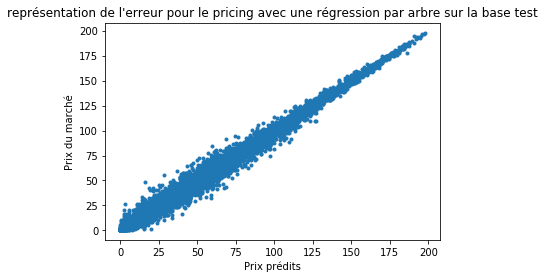

In [107]:
plt.plot(testY,y_test_predict_tree,'.')
plt.xlabel("Prix prédits")
plt.ylabel("Prix du marché")
plt.title("représentation de l'erreur pour le pricing avec une régression par arbre sur la base test")
plt.show()


In [89]:
from sklearn.ensemble import GradientBoostingRegressor

reg_boost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.3,max_depth=100, random_state=0, loss='ls').fit(trainX,trainY.values.ravel())

y_test_predict_boost=reg_boost.predict(testX)

scoreTrain_boost=reg_boost.score(trainX, trainY)
scoreTest_boost=reg_boost.score(testX, testY)
print("Score of tree on traing data:",scoreTrain_boost)
print("Score of tree on test data:",scoreTest_boost)

Score of tree on traing data: 0.9999999999536499
Score of tree on test data: 0.9914957853712137


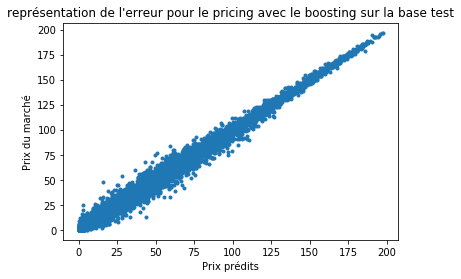

In [106]:
plt.plot(testY,y_test_predict_boost,'.')
plt.xlabel("Prix prédits")
plt.ylabel("Prix du marché")
plt.title("représentation de l'erreur pour le pricing avec le boosting sur la base test")
plt.show()
# testY en fonction de la régression sur testX avec le boosting
# attention valeurs négatives

In [91]:
print(df.shape)
data=df.to_numpy()

(9392, 10)


In [92]:
xx=data[:,:9]
yy=data[:,9:]
train=train.to_numpy()
test=test.to_numpy()

In [94]:
X_train=train[:,:9]
y_train=train[:,9:]

X_test=test[:,:9]
y_test=test[:,9:]

In [96]:

scale = StandardScaler()
scale2=  StandardScaler()
y_train_transform = scale.fit_transform(y_train)
y_test_transform = scale.transform(y_test)
x_train_transform = scale2.fit_transform(X_train)
x_test_transform = scale2.transform(X_test)


In [97]:
input1 = keras.layers.Input(shape=(9,))
x1 = keras.layers.Dense(100,activation = 'elu')(input1)
x2=keras.layers.Dense(100,activation = 'elu')(x1) 
x3=keras.layers.Dense(100,activation = 'elu')(x2) 
x4=keras.layers.Dense(100,activation = 'elu')(x3)
x5=keras.layers.Dense(1,activation = 'linear')(x4)

modelGEN = keras.models.Model(inputs=input1, outputs=x5)
modelGEN.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               1000      
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 101       
Total params: 31,401
Trainable params: 31,401
Non-trainable params: 0
_______________________________________________________

In [98]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")

modelGEN.fit(x_train_transform, y_train_transform, batch_size=32,validation_data = (x_test_transform,y_test_transform),epochs = 200, verbose = True,shuffle=1)#,callbacks=[earlystop])

Train on 40000 samples, validate on 10000 samples
Epoch 1/200
40000/40000 [==============================] - 4s 97us/step - loss: 0.0802 - val_loss: 0.0488
Epoch 2/200
40000/40000 [==============================] - 4s 93us/step - loss: 0.0444 - val_loss: 0.0394
Epoch 3/200
40000/40000 [==============================] - 3s 76us/step - loss: 0.0361 - val_loss: 0.0245
Epoch 4/200
40000/40000 [==============================] - 3s 75us/step - loss: 0.0314 - val_loss: 0.0281
Epoch 5/200
40000/40000 [==============================] - 3s 79us/step - loss: 0.0292 - val_loss: 0.0265
Epoch 6/200
40000/40000 [==============================] - 3s 75us/step - loss: 0.0282 - val_loss: 0.0248
Epoch 7/200
40000/40000 [==============================] - 3s 86us/step - loss: 0.0254 - val_loss: 0.0226
Epoch 8/200
40000/40000 [==============================] - 3s 75us/step - loss: 0.0235 - val_loss: 0.0257
Epoch 9/200
40000/40000 [==============================] - 3s 76us/step - loss: 0.0221 - val_loss: 0.0

In [99]:
y_test_predict_NN=modelGEN.predict(x_test_transform)
y_train_predict_NN=modelGEN.predict(x_train_transform)



scoreTrain_NN=sklearn.metrics.r2_score(y_train_transform ,y_train_predict_NN)
scoreTest_NN=sklearn.metrics.r2_score(y_test_transform ,y_test_predict_NN)
print("Score of tree on traing data:",scoreTrain_NN)
print("Score of tree on test data:",scoreTest_NN)


Score of tree on traing data: 0.9999495777439176
Score of tree on test data: 0.9999425059354499


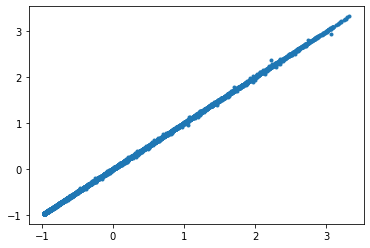

In [101]:
plt.plot(y_test_transform,y_test_predict_NN,'.')

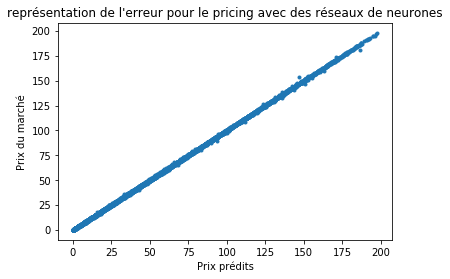

In [102]:
plt.plot(scale.inverse_transform(y_test_transform),scale.inverse_transform(y_test_predict_NN),'.')
plt.xlabel("Prix prédits")
plt.ylabel("Prix du marché")
plt.title("représentation de l'erreur pour le pricing avec des réseaux de neurones")
plt.show()

In [180]:
def model(kLog,S0,theta,V0,sigma,rho,r,kappa,tau):
    X=scale2.transform(np.array([[kLog,S0,theta,V0,sigma,rho,r,kappa,tau]]))
    return(scale.inverse_transform(modelGEN.predict(X)))
                       

In [181]:
model(2.613564,45.331791,0.028774,0.283051,0.204793,-0.630907,0.094530,0.720222,1.682717)

array([[33.857754]], dtype=float32)

Text(0.5, 1.0, 'évolution du peix du call en fonction de tau')

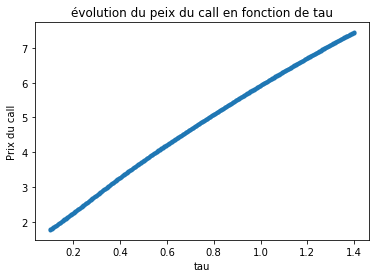

In [182]:
size=500
kLog=3.5
S0=0.9*np.exp(kLog)
theta=0.3
V0=0.3
sigma=0.15
rho=-0.15
r=0.08
kappa=0.9
tau=1

# kLog,S0,theta,V0,sigma,rho,r,kappa,tau,

tau_list = np.linspace(0.1, 1.4, size)
callPrice= np.zeros(size)

for i in range(0,size):
    callPrice[i]=model(kLog,S0,theta,V0,sigma,rho,r,kappa,tau_list[i])

    
plt.plot(tau_list,callPrice,'.')
plt.xlabel("tau")
plt.ylabel("Prix du call")
plt.title("évolution du peix du call en fonction de tau")


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  app.launch_new_instance()


Text(0.5, 0, 'Prix')

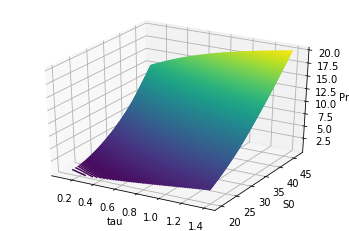

In [183]:
from mpl_toolkits import mplot3d
size=100
S0_list = np.linspace(0.6*np.exp(kLog), 1.4*np.exp(kLog), size)
tau_list = np.linspace(0.1, 1.4, size)


X, Y = np.meshgrid(S0_list, tau_list)
callPrice = np.zeros((size, size))
for i in range(0,size):
    for j in range(0,size):
        callPrice[i][j]=model(kLog,X[i][j],theta,V0,sigma,rho,r,kappa,Y[i][j])


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(Y, X, callPrice, 500,cmap='viridis', edgecolor='none')
ax.set_xlabel('tau')
ax.set_ylabel('S0')
ax.set_zlabel('Prix')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  app.launch_new_instance()


Text(0.5, 0, 'Prix')

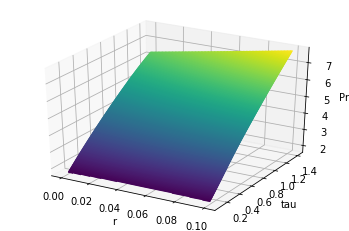

In [184]:
size=100
r_list = np.linspace(0.0, 0.1, size)
tau_list = np.linspace(0.1, 1.4, size)



X, Y = np.meshgrid(r_list, tau_list)
callPrice = np.zeros((size, size))
for i in range(0,size):
    for j in range(0,size):
        callPrice[i][j]=model(kLog,S0,theta,V0,sigma,rho,X[i][j],kappa,Y[i][j])


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, callPrice, 500,cmap='viridis', edgecolor='none')
ax.set_xlabel('r')
ax.set_ylabel('tau')
ax.set_zlabel('Prix')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'edgecolor'


Text(0.5, 0, 'Prix')

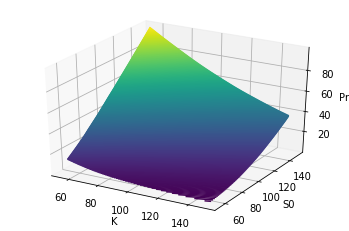

In [185]:
size=100
S0_list = np.linspace(55, 150, size)
K_list = np.linspace(55, 150, size)




X, Y = np.meshgrid(K_list, S0_list)
callPrice = np.zeros((size, size))
for i in range(0,size):
    for j in range(0,size):
        callPrice[i][j]=model(np.log(X[i][j]),Y[i][j],theta,V0,sigma,rho,r,kappa,tau)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, callPrice, 500,cmap='viridis', edgecolor='none')
ax.set_xlabel('K')
ax.set_ylabel('S0')
ax.set_zlabel('Prix')

In [ ]:
tau=0.1

callPrice = np.zeros((size, size))
for i in range(0,size):
    for j in range(0,size):
        callPrice[i][j]=model(np.log(X[i][j]),Y[i][j],theta,V0,sigma,rho,r,kappa,tau)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, callPrice, 1000,cmap='viridis', edgecolor='none')
ax.set_xlabel('K')
ax.set_ylabel('S0')
ax.set_zlabel('Prix')